In [61]:
!pip install kagglehub --upgrade

In [62]:
import kagglehub

# Downloading the dataset from kaggle
kagglehub.dataset_download("undefinenull/million-song-dataset-spotify-lastfm")

'/kaggle/input/million-song-dataset-spotify-lastfm'

In [63]:
# Importing required libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Importing songs dataset and users dataset
data_path = Path("/root/.cache/kagglehub/datasets/undefinenull/million-song-dataset-spotify-lastfm/versions/1")
songs_data_path = data_path / 'Music Info.csv'
users_data_path = data_path / 'User Listening History.csv'

In [65]:
# Songs_data
songs_df = pd.read_csv(songs_data_path, usecols=["track_id","name","artist","spotify_preview_url"])
songs_df.head()

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...


In [66]:
# Downloading espically for dataframe
!pip install dask[dataframe]

In [67]:
# Importing Dask
import dask.dataframe as dd

# Load the dataset using Dask
df = dd.read_csv(users_data_path)

# Check the first few rows to verify the data
df.head()

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


*Dask store the entire dataset in the form of chunks, so if you try to print, it will show empty cells*

In [68]:
df

,track_id,user_id,playcount
npartitions=9,,,
,string,string,int64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [11]:
df.npartitions

9

*The default size of each chunk formed by Dask is approx 64MBs, Thats why we see 9 chunks of our dataframe*

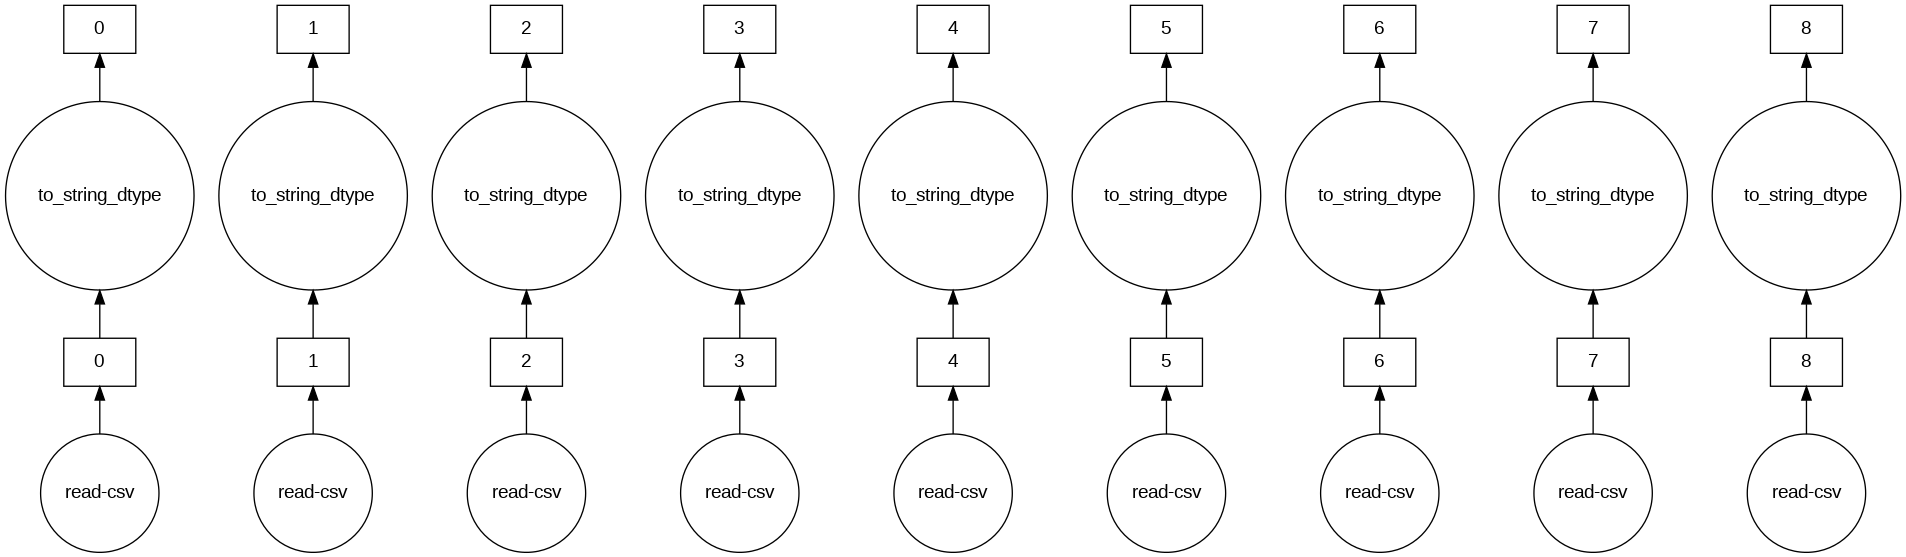

In [69]:
# Visualizing the flow to parallel processing
df.visualize(tasks=True)

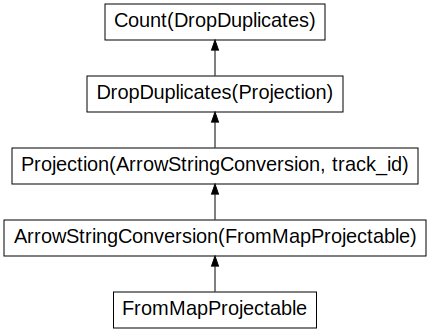

In [70]:
# Number of unique tracks in the data
unique_tracks = df.loc[:,"track_id"].nunique()
unique_tracks.visualize()

*Everytime you want to fetch something from dask dataframe you have to use "compute" method - Basically conversion of dask dataframe to pandas dataframe*

In [71]:
unique_tracks = unique_tracks.compute()
print(unique_tracks)

30459


In [72]:
# Number of unique users in the data
unique_users = df.loc[:,"user_id"].nunique()
unique_users = unique_users.compute()
print(unique_users)

962037


*There are 30459 unique songs with 962037 unique users*

In [73]:
# List of unique track_ids
unique_track_ids = df.loc[:,"track_id"].unique().compute()
unique_track_ids = unique_track_ids.tolist()
len(unique_track_ids)

30459

In [74]:
# Filtering the songs dataframe on the basis of the songs which were heard by at least one time
filtered_songs = songs_df[songs_df["track_id"].isin(unique_track_ids)]
filtered_songs.reset_index(drop=True, inplace=True)
filtered_songs

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
2,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
3,TRXOGZT128F424AD74,Karma Police,Radiohead,https://p.scdn.co/mp3-preview/5a09f5390e2862af...
4,TRUJIIV12903CA8848,Clocks,Coldplay,https://p.scdn.co/mp3-preview/24c7fe858b234e3c...
...,...,...,...,...
30454,TRXWSIN128F9339A11,Infinite Love Song,Maximilian Hecker,https://p.scdn.co/mp3-preview/8b3d529025fe3c60...
30455,TRPIGDW12903CDEB2D,Slip of the Lip,Fact,https://p.scdn.co/mp3-preview/cf64490291f9a600...
30456,TRQYCFV128F9322F50,Ryusei Rocket,アンティック-珈琲店-,https://p.scdn.co/mp3-preview/d2668a5a3e0b1fda...
30457,TRHQCSH128F42724B7,Colors Of The Wind,ACIDMAN,https://p.scdn.co/mp3-preview/8e22a7052ef3ecf7...


---

In [75]:
# Importing necessary libraries
import dask.dataframe as dd
import numpy as np
from scipy.sparse import csr_matrix

In [80]:
# Step 1: Load data with Dask - Assume the dataset is in a CSV file
df = dd.read_csv(users_data_path)

In [81]:
# Step 2: Ensure playcount is numeric
df['playcount'] = df['playcount'].astype(np.float64)
df = df.categorize(columns=['user_id', 'track_id']) # changing the astype of user_id and track_id to "dask category" using categorize function
# Basically this function will create a seperate list of all the unique individuals('user_id', 'track_id') in the column
df.head()

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0


In [82]:
# Step 3: Convert user_id and track_id to numeric indices
# This is necessary for creating a sparse matrix later
user_mapping = df['user_id'].cat.codes # .cat is an accessor just like .str and .codes is encoding into integers
track_mapping = df['track_id'].cat.codes

df = df.assign(
    user_idx=user_mapping,
    track_idx=track_mapping
) # We are concatinating those columns into our primary dataset
df.head()

,track_id,user_id,playcount,user_idx,track_idx
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,10705
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,7334
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,14212
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,23206
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,8936


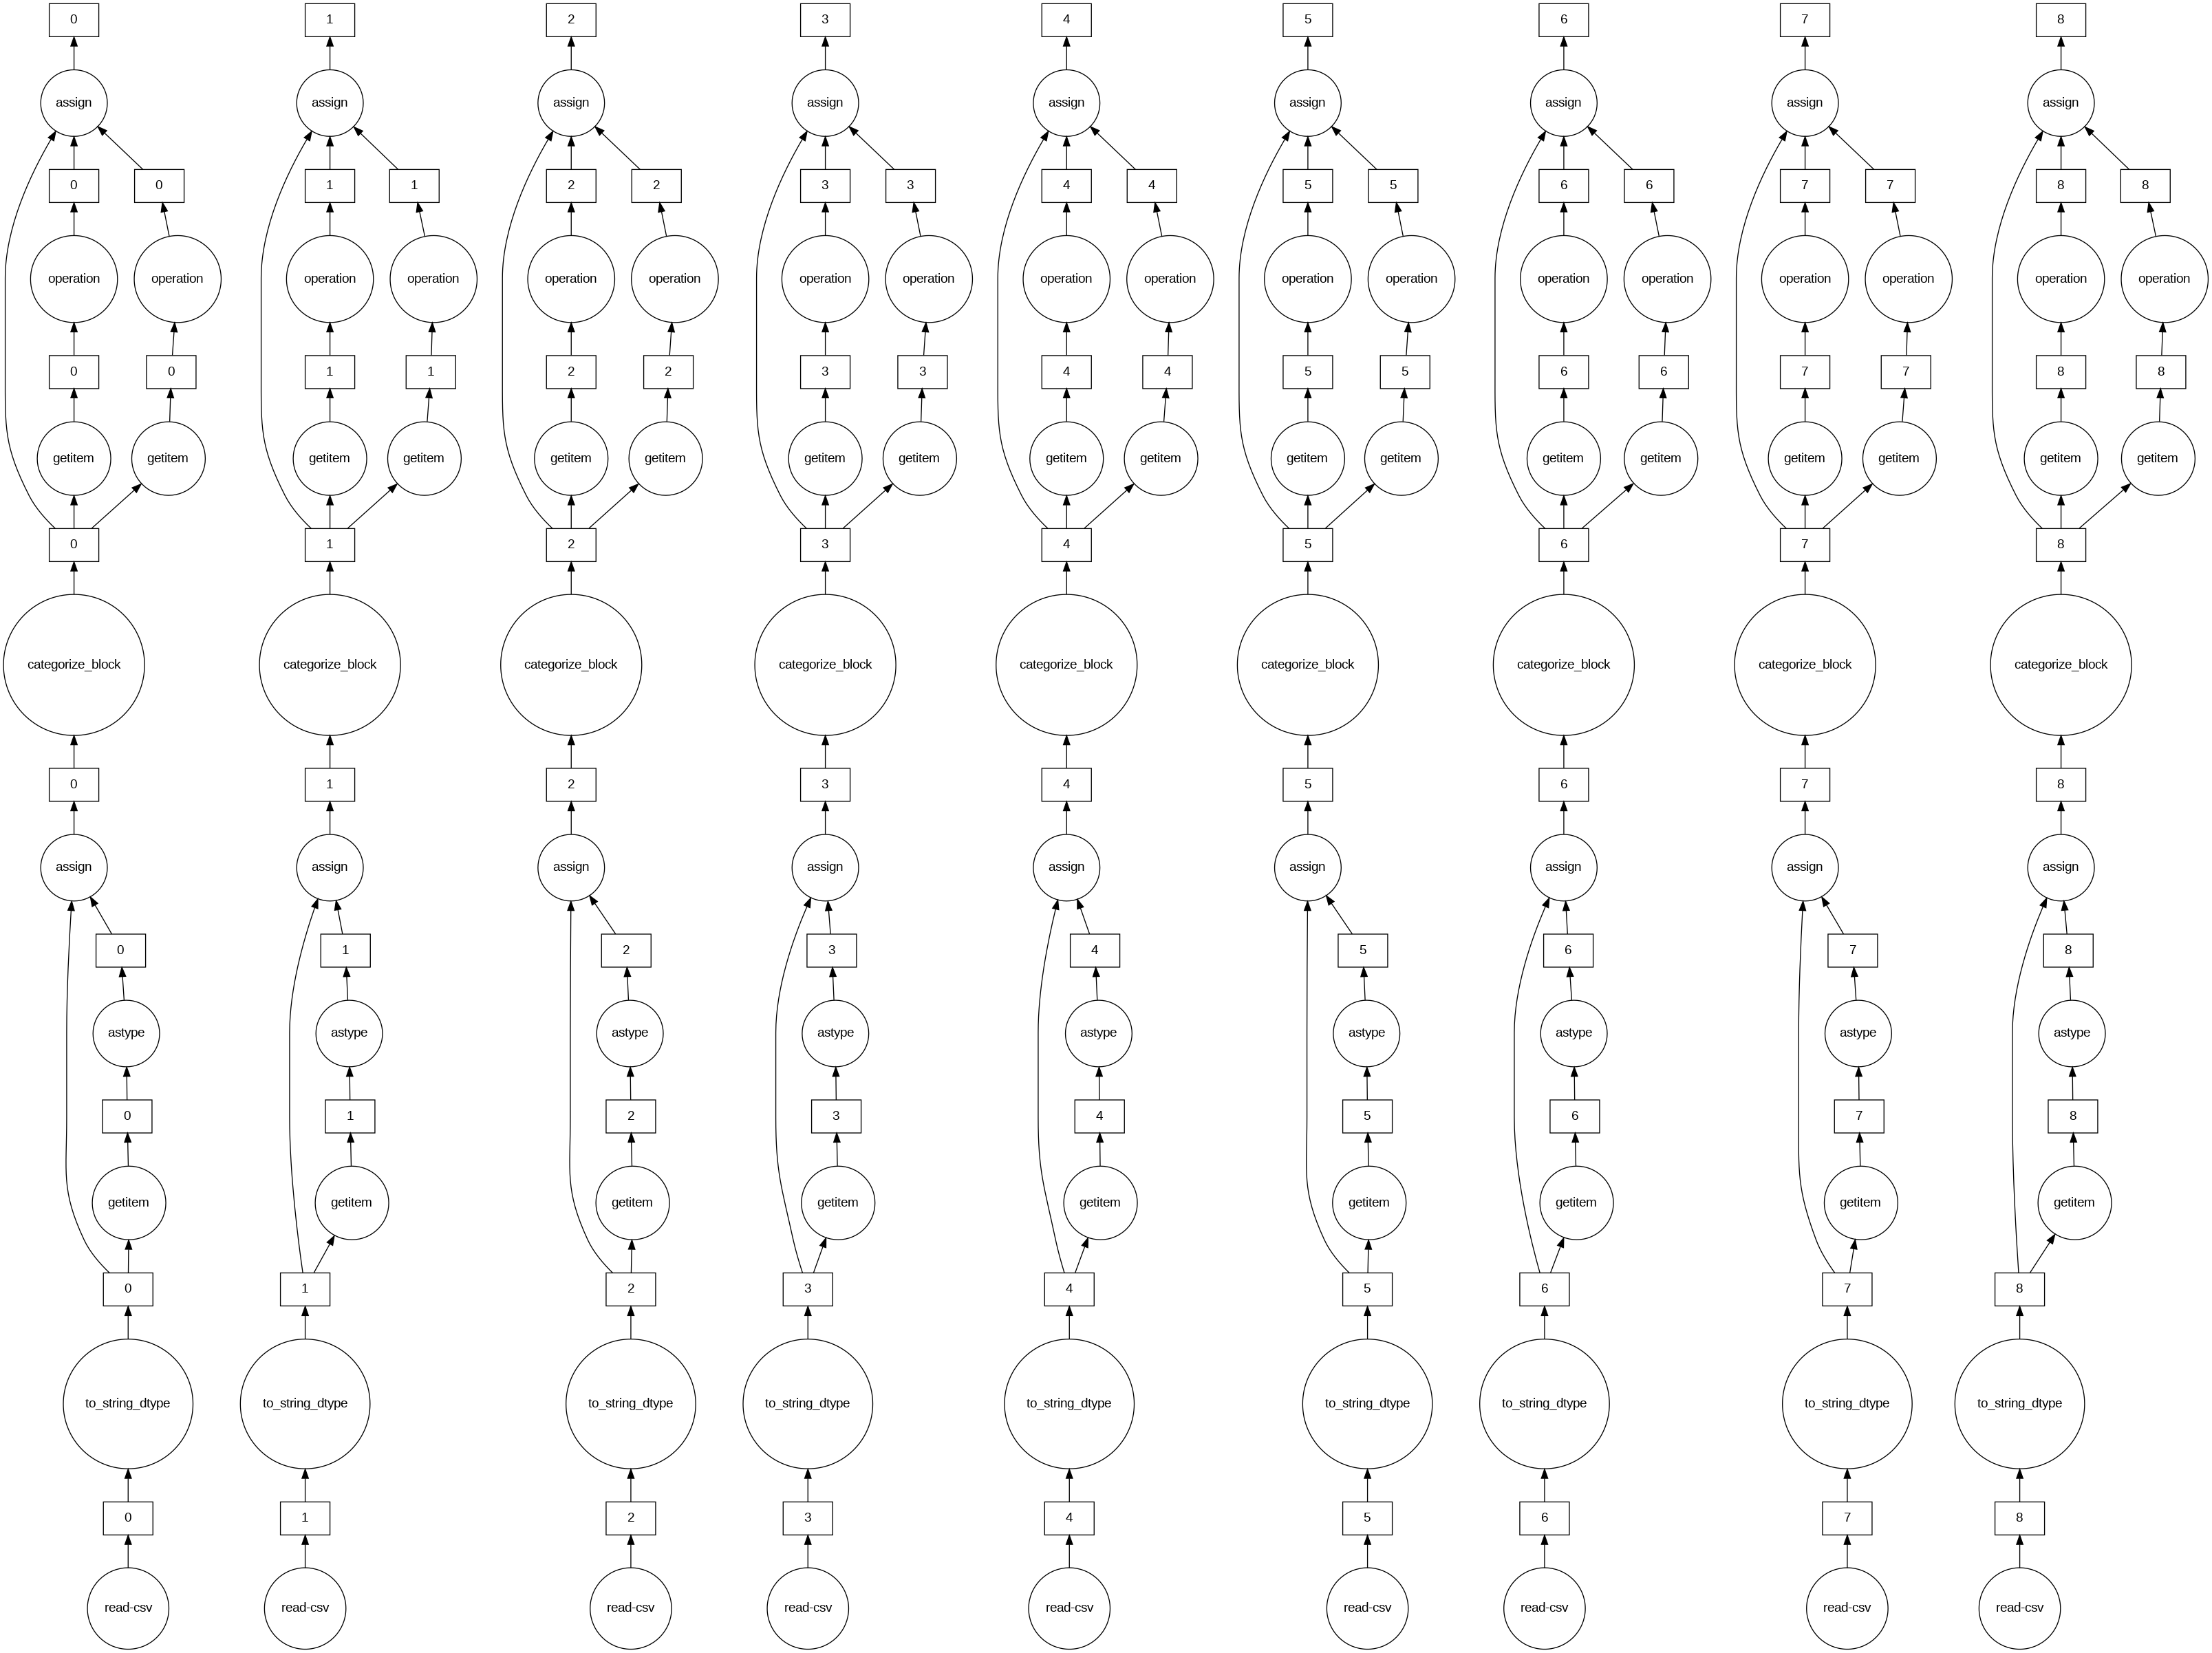

In [83]:
df.visualize(tasks=True)

*Dask doesn't support pivot tables directly, so we aggregate manually, because pivot tabel requires 60GB of size to store interaction matrix.*

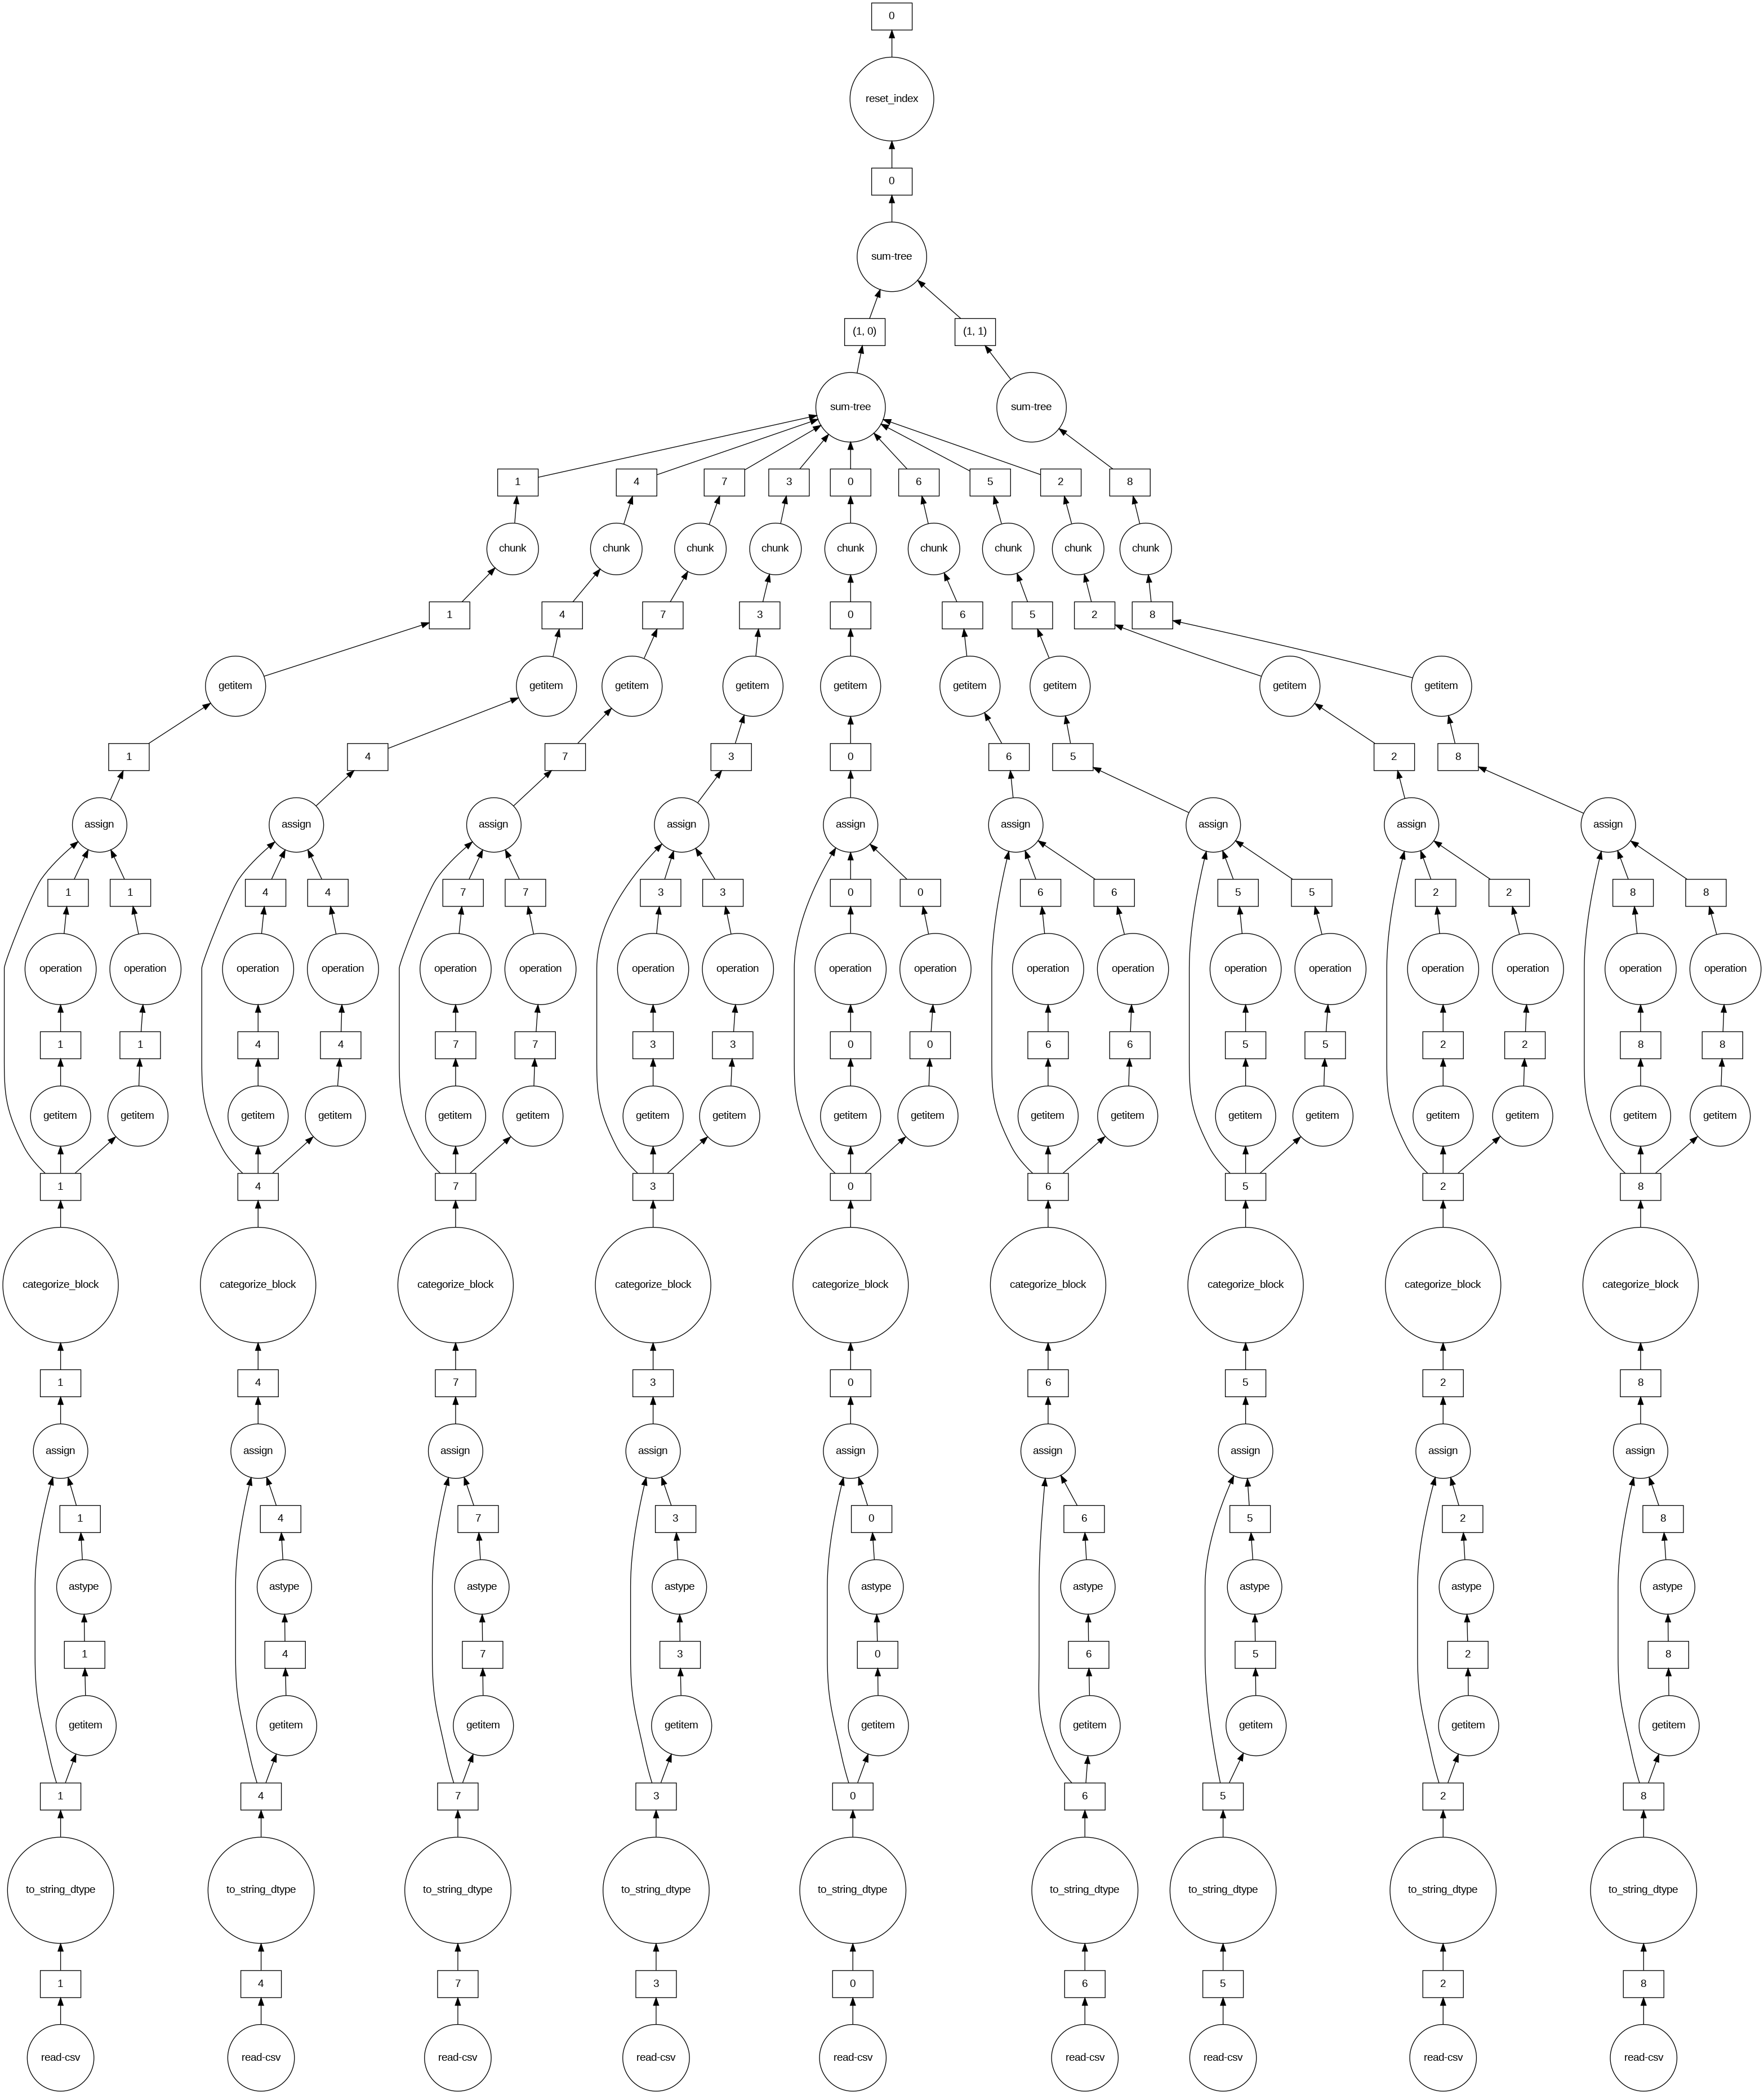

In [84]:
# Step 4: Compute the interaction matrix
interaction_array = df.groupby(['track_idx', 'user_idx'])['playcount'].sum().reset_index()
interaction_array.visualize(tasks=True)

In [86]:
interaction_array = interaction_array.compute()
interaction_array.head()

,track_idx,user_idx,playcount
0,0,15780,3.0
1,0,76968,1.0
2,0,134525,2.0
3,0,231541,1.0
4,0,305348,1.0


In [87]:
# Step 5: Create a sparse matrix
# Collect the data into a NumPy-friendly format
row_indices = interaction_array['track_idx']
col_indices = interaction_array['user_idx']
values = interaction_array['playcount']

In [88]:
# Build a sparse matrix
n_tracks = unique_tracks
n_users = unique_users

sparse_matrix = csr_matrix((values, (row_indices, col_indices)), shape=(n_tracks, n_users))

print("Sparse matrix shape:", sparse_matrix.shape)
print("Non-zero elements:", sparse_matrix.nnz)

Sparse matrix shape: (30459, 962037)
Non-zero elements: 9711301


In [89]:
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9711301 stored elements and shape (30459, 962037)>

In [90]:
(sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))*100
# Only 0.03% filled with non-zero values

0.033141335019756815

In [91]:
sparse_matrix[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 161 stored elements and shape (1, 962037)>

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

In [93]:
np.where(df['track_id'].cat.categories == "TROINZB128F932F740") # .categories will return the decoded form of all the categories - Values before encoding

(array([17018]),)

In [94]:
ind = 17018 # This is the encoding form of "TROINZB128F932F740"

In [95]:
input_array = sparse_matrix[ind]
input_array

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 610 stored elements and shape (1, 962037)>

In [99]:
similarity_scores = cosine_similarity(input_array, sparse_matrix)
print(np.sort(similarity_scores)[0][::-1])
print(similarity_scores.shape)

[1.         0.08225488 0.07217127 ... 0.         0.         0.        ]
(1, 30459)


In [100]:
np.argsort(similarity_scores.ravel())[-6:][::-1]

array([17018, 24529, 28964,  3620,  9470,  7882])

In [101]:
recommendations = df['track_id'].cat.categories[np.argsort(similarity_scores.ravel())[-6:][::-1]]
recommendations

Index(['TROINZB128F932F740', 'TRURCEI12903CA4395', 'TRYLWIW12903CA438D',
       'TRCVMAF12903D00E61', 'TRHRNEE12903CFDBD4', 'TRGEUXY128F4226B26'],
      dtype='string', name='track_id')

In [115]:
filtered_songs[filtered_songs["name"] == "Objection (Tango)"]

,track_id,name,artist,spotify_preview_url


In [103]:
filtered_songs[filtered_songs["track_id"].isin(recommendations)]

,track_id,name,artist,spotify_preview_url
3337,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...
8871,TRCVMAF12903D00E61,Delirium,Satyricon,https://p.scdn.co/mp3-preview/d039120c4f5f1e8d...
17287,TRGEUXY128F4226B26,Monday Massacre,Mr. Oizo,https://p.scdn.co/mp3-preview/4d6dbacc93e3ef7e...
26611,TRYLWIW12903CA438D,Dreadlock,Future Prophecies,https://p.scdn.co/mp3-preview/13ca5435549b0e46...
26701,TRURCEI12903CA4395,Bring the Noise,Future Prophecies,https://p.scdn.co/mp3-preview/d558b155fb9dcfe4...
27774,TRHRNEE12903CFDBD4,Lunar Sea,Camel,https://p.scdn.co/mp3-preview/8bf35f13a0ece173...


In [121]:
def collaborative_recommendation(song_name,user_data,songs_data,interaction_matrix,k=10):
    # fetch the row from songs data
    song_row = songs_data[songs_data["name"] == song_name]
    print("Current Song -", song_name) # Delete
    # print(song_row)
    # track_id of input song
    input_track_id = song_row['track_id'].values.item()
    # print(input_track_id)
    # index value of track_id
    ind = np.where(user_data['track_id'].cat.categories == input_track_id)[0].item()
    # print(ind)
    # fetch the input vector
    input_array = interaction_matrix[ind]
    # get similarity scores
    similarity_scores = cosine_similarity(input_array, interaction_matrix)
    # get top k recommendations
    recommendation_track_ids = df['track_id'].cat.categories[np.argsort(similarity_scores.ravel())[-k-1:][::-1]]
    # print(recommendation_track_ids)
    # get top scores
    top_scores = np.sort(similarity_scores.ravel())[-k-1:][::-1]
    # print(top_scores)
    # get the songs from data and print
    temp_df = pd.DataFrame({"track_id":recommendation_track_ids.tolist(),
                            "score":top_scores})
    # print(temp_df)
    top_k_songs = (
                    songs_data
                    .loc[songs_data["track_id"].isin(recommendation_track_ids)]
                    .merge(temp_df,on="track_id")
                    .sort_values(by="score",ascending=False)
                    .drop(columns=["track_id","score"])
                    .reset_index(drop=True)
                    )
    return top_k_songs

In [124]:
collaborative_recommendation(
    song_name="Hips Don't Lie",
    user_data=df,
    songs_data=filtered_songs,
    interaction_matrix=sparse_matrix,
    k=10
)

Current Song - Hips Don't Lie


,name,artist,spotify_preview_url
0,Hips Don't Lie,Shakira,https://p.scdn.co/mp3-preview/3859547944f57cfb...
1,Can't Stop The Killer,Emery,https://p.scdn.co/mp3-preview/12bb12c75a6563f8...
2,Ayo Technology,Milow,https://p.scdn.co/mp3-preview/f47192a476b16087...
3,Alejandro,Lady Gaga,https://p.scdn.co/mp3-preview/fc79c08bc9f46cca...
4,Imma Be,Black Eyed Peas,https://p.scdn.co/mp3-preview/bb97ba1db66b37e2...
5,Don't Cha,The Pussycat Dolls,https://p.scdn.co/mp3-preview/7021c37e3e36fe61...
6,"Jumpin', Jumpin'",Destiny's Child,https://p.scdn.co/mp3-preview/900921fe7ea36b00...
7,Sexy Bitch,David Guetta,https://p.scdn.co/mp3-preview/282100e2282a5d4e...
8,Party In The U.S.A.,The Barden Bellas,https://p.scdn.co/mp3-preview/f8c5ff9e6aebca46...
9,Halo,Depeche Mode,https://p.scdn.co/mp3-preview/78eac59c0b2a7067...
